# Project: Auto-trading in a Network of Connected Autonomous Agents
In this project, we will further explore learning approaches in autonomous trading by simulating a network of autonomous trading agents. These agents will observe expert traders who utilize a specific [technical analysis approach](https://en.wikipedia.org/wiki/Technical_analysis) to establish their state. The expert technical traders monitor market price trends, and then non-expert trading agents (us) observe the actions of the technical traders. We'll use `1-min` aggregate data of the [`QQQ` ETF year to date in 2024](https://oneminutedata.com/free-intraday-data) as our trading instrument.

## Learning objectives
* __Prerequisites__: Before setting up the simulation, we'll load and process the `1-min` aggregate share price data for `QQQ.` Then, we set some constant values that we'll use later.
* __Task 1__: In this task, we'll compute the simple moving average of the typical price (`tp`) of `QQQ,` and develop a decision boundary which we'll use in the subsequent tasks to formulate a trading policy for cells on the edge of our grid world.
* __Task 2__: In this task, we will create the non-expert interior agent policies. These policies will be used to simulate the dynamics of the world in the next task. Unlike the example we worked through, here we will manually set up the policy so that we can adjust the choices our agents will make based on their environment.
* __Task 3__: In this task, we'll take the decision boundary ideas we developed in Task 1 and the internal agent policy we created in Task 2 and construct a simulation of how a network of autonomous, connected trading agents behaves over time. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Constants and process the aggregate share price data
Before setting up the simulation, we load and process the 1-minute aggregate share price data for `QQQ.` Then, we set some constant values that we'll use throughout the rest of the notebook. 

### Load and process the `QQQ` data
The 1-minute aggregate `QQQ` data used in this project (which is YTD for the `2024` trading year) was downloaded from [oneminutedata.com](https://oneminutedata.com). The `QQQ` dataset, which is stored as a [comma-separated value (CSV) file](https://en.wikipedia.org/wiki/Comma-separated_values), is loaded using the [read method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) as a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl). We save the `QQQ` data in the `share_price_data_df::DataFrame` variable:

In [6]:
share_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "QQQ-OHLC-1-min-aggregate-2024.csv"), DataFrame);

Next, compute the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) using [the `typicalprice(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.typicalprice) for the `share_price_data_df::DataFrame.` We save the typical price (defined as (h+l+c)/3) in the `typical_price_array::Array{Float64,1}` array.

In [8]:
typical_price_array = typicalprice(share_price_data_df);

Next, augment the `share_price_data_df::DataFrame` to include the `typical_price_array::Array{Float64,1}` array, where we store this data in the `:typicalprice::Symbol` column. 
* What is the `:` about in `:typicalprice`? We add the typical price `tp` data to the `share_price_data_df::DataFrame` in the `:typicalprice` column. The `:` prefix indicates we use a [Julia Symbol type](https://docs.julialang.org/en/v1/base/base/#Core.Symbol) for this data column. The columns of a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl) are [Julia Symbols](https://docs.julialang.org/en/v1/base/base/#Core.Symbol), which are sort of like Strings but with a few interesting differences. [Check out the docs here!](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols)

In [10]:
share_price_data_df[:,:typicalprice] = typical_price_array; # now the dataframe has the typical price data (h+l+c)/3

Finally, let's specify some constants that we'll use later. See the comments next to the value for a description of what it is, and permissible values.

In [12]:
number_of_trading_periods = length(typical_price_array); # how many minutes of 2024 data do we have?
start_index = 60;  # index to start viewing the data. This value needs to >= 1
stop_index = 1560; # index where we stop view the data. This value needs to be <= to number_of_trading_periods
view_range = range(start_index, stop = 1560, step = 1) |> collect; # view_range is the range we use to look at (simulate) the data
number_of_colors = 3; # each the number of colors, i.e., the number of possible states for each agent. 
radius = 4; # size of the neighborhood an agent looks at. DO NOT CHANGE
number_of_rows = 2^8; # number of rows in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_columns = 2^8; # number of cols in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_agents = number_of_rows*number_of_columns; # the number of agents in the grid
middle = (number_of_rows / 2) |> Int; # the index of the middle agent (we have a square grid by default, so middle x = middle y)

### Edge cells
The `edge_coordinate_dictionary::Dict{Int64, Tuple{Int, Int64}}` dictionary holds information about the location and index of the `active` edge cells, i.e., those edge cells that are watching the external world and use some decision rule (that we develop below) to adjust their state. The keys of `edge_coordinate_dictionary` are the edge cell indexes, while the values are the `(i,j)` coordinates of the edge cell in our grid world. 
* In the default implementation, we have three `active` edge cells: the top middle, left middle, and bottom middle cell. The right middle cell is inactive, so we generate potentially non-symmetric patterns in the grid-world. Want to change this? No problem. The code will adjust to your choices of edge cells. 

In [14]:
edge_coordinate_dictionary = Dict{Int64, Tuple{Int,Int64}}();
counter = 1;
for row ∈ 1:number_of_rows
    for col ∈ 1:number_of_columns

        if (row == 1 && col == middle)
            edge_coordinate_dictionary[counter] = (row,col);
            counter += 1;
        elseif (row == number_of_rows && col == middle)
            edge_coordinate_dictionary[counter] = (row,col);
            counter += 1;
        elseif (row == middle && col == 1)
            edge_coordinate_dictionary[counter] = (row,col);
            counter += 1;
        end
    end
end
edge_coordinate_dictionary

Dict{Int64, Tuple{Int64, Int64}} with 3 entries:
  2 => (128, 1)
  3 => (256, 128)
  1 => (1, 128)

In [15]:
number_of_edge_cells = length(edge_coordinate_dictionary);

### Color dictionary
* Construct the `my_color_dictionary::Dict{Int64, RGB}` dictionary, which maps the agent state values, e.g., $s\in\left\{0,1,2\right\}$ for a `number_of_colors = 3` system, to an [RGB color type exported by the Colors.jl package](https://github.com/JuliaGraphics/Colors.jl). The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary are the states, e.g., $s\in\left\{0,1,2\right\}$ while the values correspond to colors associated with those states.
* Use the [`colorant` shortcut syntax exported by Colors.jl](https://juliagraphics.github.io/Colors.jl/stable/constructionandconversion/#Color-Parsing) to create instances of [named colors provided by Colors.jl](https://juliagraphics.github.io/Colors.jl/stable/namedcolors/). By default, we map the buy state (`s = 0`) to `lightgreen,` the hold state (`s = 1`) to `white/gray`, and the sell state (`s = 2`) to `red.` However, you can change this mapping to whatever they want.

In [17]:
my_color_dictionary = Dict{Int64, RGB}();
my_color_dictionary[0] = colorant"lightgreen";  # 0: buy state
my_color_dictionary[1] = colorant"gray95";      # 1: hold state
my_color_dictionary[2] = colorant"red";         # 2: sell state

## Task 1: Compute simple moving average trade signal trajectory
In this task, we'll compute the simple moving average of the typical price of `QQQ,` and develop a decision boundary which we'll use in the subsequent tasks to formulate a trading policy for cells on the edge of our grid world. We'll use an [incremental simple moving average](https://en.wikipedia.org/wiki/Moving_average) where the average price is updated with new data as the algorithm marches through time. 
Let the typical price in period $\tau$ be given by $S_{\tau}$ (units: `USD/share`) and the moving average of the `tp` at time $\tau$ be given by $\hat{S}_{\tau}$ (units: `USD/share`). 
$$
\begin{equation}
\hat{S}_{\tau} = \hat{S}_{\tau - 1} + \alpha(\tau)\cdot\left(S_{\tau} - \hat{S}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function`.  The `learning function` controls how much new information is included in the update between $(\tau-1)\rightarrow\tau$. For example, if $\alpha(\tau) = 0$, no new information is added to the updated average estimate. 
* __What value for $\alpha(\tau)$__? A simple moving average computed over a time window of length $\mathcal{L}\geq{1}$ has a `learning function` given by $\alpha(\tau) = \mathcal{L}^{-1}$. Thus, as the window length increases in size, i.e., $\mathcal{L}\rightarrow\infty$, the simple moving average learning rate goes to zero $\alpha(\tau) \rightarrow{0}$. We'll select a $\alpha(\tau)$ value to capture some desired time scale.

Let's specify a constant value for the `learning function` such that $0<\alpha(\tau)<1$, and save it in the `α::Float64` variable (units: `1/min`). Notice the units; what does this look like?

In [19]:
α = (1/60); # students can update this! what happens if we recompute the mvap_array with diff values of α?

Next, using the incremental update expression above, let's populate the `mvap_array::Array{Float64,1}` array. First, we initialize some memory, and next, we initialize the average `mtypicalprice` series with the `typicalprice` value, in this case, the actual `typicalprice` value. Thus, at the first time step (array index `1`), the `mtypicalprice = typicalprice`. Then, we compute the moving average using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for).
* For each time step `2 ... number_of_trading_periods`, we use the incremental update expression to compute the average value and store it in the `mtypical_price_array::Array{Float64,1}` array.

In [21]:
mtypical_price_array = Array{Float64,1}(undef, number_of_trading_periods);
mtypical_price_array[1] = typical_price_array[1]; 

for i ∈ 2:number_of_trading_periods
    previous_mtp = mtypical_price_array[i-1];
    current_tp = typical_price_array[i];
    mtypical_price_array[i] = previous_mtp + α*(current_tp - previous_mtp);
end

#### Visualize the MTP
`Unihide` the code block below to see how we plotted the actual and moving volume weighted average for `1-min` aggregates of `QQQ.`
* The `typicalprice` for `QQQ` is shown in the blue-line, while the moving average of the typical price (mtp) is shown by the red-line. The mtp is a smoothed and lagged version of the `typicalprice` with the high-frequency information removed. Thus, it gives a slower picture of the `typicalprice` dynamics. The $\alpha(\tau)$ parameter controls the inclusion of fast or slow dynamics.
* __What is the signifinance of $\alpha(\tau)$__? The parameter $\alpha(\tau)$ represents a time constant measured in units of `1/min`. When $\alpha(\tau)$ is large, the moving volume-weighted average price (mtp) trajectory includes high-frequency data. Conversely, when $\alpha(\tau)$ is small, only slow dynamics or low-frequency information is retained in the mtp. This means that data with a frequency of $\alpha(\tau)$ or below is included in the mtp, while data with a frequency greater than $\alpha(\tau)$ is excluded.

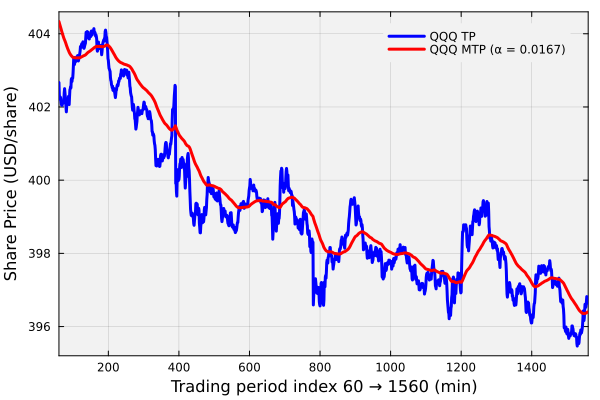

In [23]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, view_range, typical_price_array[view_range],c=:blue, xlims=(first(view_range), last(view_range)), lw=3, label="QQQ TP")
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw=3, label="QQQ MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index $(first(view_range)) → $(last(view_range)) (min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

### TODO: Develop a decision boundary
The moving average typical price (mtp) gives us a reference trajectory to use as a decision boundary, i.e., a `QQQ` price level that we'll use to make `{buy, hold, sell}` decisions. 
* `Hypothesis`: If `typicalprice` < `mtypicalprice,` we'll buy shares as we expect `QQQ` to be oversold, and the price will revert to the `mtypicalprice` value. On the other hand, if `typicalprice` > `mtypicalprice,`  we will sell shares. In this case, we expect that `QQQ` is overbought, and the price will drop to the `mtp` price.

However, let's refine this hypothesis further and add a buffer of size $\pm\,\beta\cdot\sigma$ around the `mtypicalprice` trajectory in which we hold, i.e., do not sell any shares. The multiplier $\beta$ is a user-adjustable hyperparameter, while $\sigma$ is the standard deviation of the `mtypicalprice,` that we calculate next. This is [a similar concept to Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands).

#### Calculate the decision boundary standard deviation
Like the incremental moving average for the share price shown above, suppose the average standard deviation at time step $\tau$ is given by $\hat{\sigma}_{\tau}$. We can incrementally update this value as new data becomes available. By analogy to the price expression, we propose an update rule for the standard deviation, which we'll use in our decision process, of the form:
$$
\begin{equation}
\hat{\sigma}_{\tau} = \hat{\sigma}_{\tau - 1} + \alpha(\tau)\cdot\left(\epsilon_{\tau} - \hat{\sigma}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function` from above, and $\epsilon_{\tau}$ is the 1-step standard deviation given by the expression:
$$
\begin{equation}
\epsilon_{\tau} = \sqrt{\left(S_{\tau} - \hat{S}_{\tau}\right)^2}
\end{equation}
$$
The $S_{\tau}$ value denotes the typical price at time $\tau$, while the $\hat{S}_{\tau}$ term denotes the moving average typical price (mtp) at time $\tau$. Thus, the $\epsilon_{\tau}$ term measures the residual between the `tp` and the `mtp` price. 
* To implement the moving average calculation, first, we allocate some space for the $\hat{\sigma}_{\tau}$ values in the `decision_boundary_array::Array{Float64,1}` array. We then initialize the first value of this series to zero, i.e., we have complete knowledge of the average price at index `1` because we know that `tp = mtp` at index `1,` thus $\hat{\sigma}_{1} = 0$. Then, we process each time step `2 ... number_of_trading_periods` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we implement the incremental update expression above and store the result in the `decision_boundary_array::Array{Float64,1}` array.

In [26]:
decision_boundary_array = Array{Float64,1}(undef, number_of_trading_periods);
decision_boundary_array[1] = 0.0;
for i ∈ 2:(number_of_trading_periods)
    previous_decision_boundary = decision_boundary_array[i-1];
    ϵ = (typical_price_array[i] - mtypical_price_array[i])^2 |> x -> sqrt(x);
    decision_boundary_array[i] = previous_decision_boundary + α*(ϵ - previous_decision_boundary);
end

#### Visualize the decision boundary
Let's plot the `decision_boundary_array,` i.e., the $\hat{\sigma}_{\tau}$ values, along with the tp and mtp trajectories, to see the decision boundaries. First, select a value for the multiplier hyperparameter $\beta$. 
* __What does $\beta$ do__? This user-adjustable parameter controls the width of the hold band. The $\beta$ parameter is akin to a [z-value in statistics](https://en.wikipedia.org/wiki/Standard_score); large values of $\beta$ will lead to a wide hold band, which means only extreme events will be clearly classified as buy or sell signals. On the other hand, small $\beta$ values will allow more buy and sell moves. For now, let's set `β = 1`, i.e., $\pm$ one standard deviation of moves will be hold moves, and approximately 30% of price moves will generate buy or sell signals. 

In [28]:
β = 1.0;

`Unhide` the code block below to reveal the code for plotting the tp, the mtp, and the decision boundary trajectory for the `β = 1` case.
* The tp is shown by the blue line, the moving volume-weighted average price (mtp) is shown in the red line, and the $\pm\,\beta\cdot\hat{\sigma}_{\tau}$ region around the mtp is shown in the gray shaded region. We can now use the hold region, i.e., the gray region, as the boundary for our auto-trading agent.
* Values of tp inside the gray region indicate our agent is in the hold state. On the other hand, if the tp falls below the gray region, the agent will be in the buy state. Finally, for tp values above the gray region, the agent will be in the sell state.
* We can imagine that each agent has a unique risk tolerance represented by a different value of $\beta$, and also a different value for the `learning function` $\alpha(\tau)$. Consequently, each agent might make different decisions based on their parameter values.

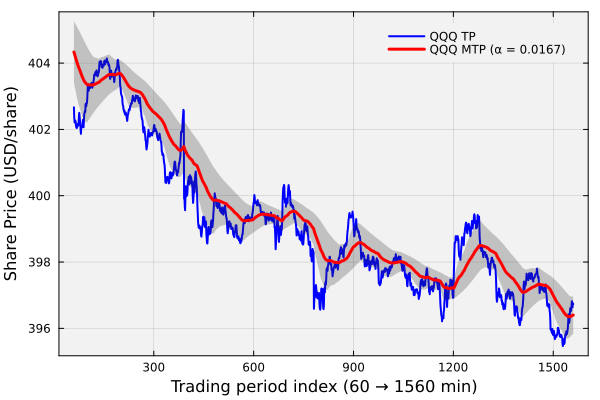

In [85]:
let    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, view_range, typical_price_array[view_range],c=:blue, lw=2, label = "QQQ TP")

    UB = mtypical_price_array[view_range] + β*decision_boundary_array[view_range];
    LB = mtypical_price_array[view_range] - β*decision_boundary_array[view_range];
    plot!(view_range, mtypical_price_array[view_range], fillrange = UB, label="", alpha=0.25, c=:gray20)
    plot!(view_range, mtypical_price_array[view_range], fillrange = LB, label="", alpha=0.25, c=:gray20)
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw = 3, label="QQQ MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

## Task 2: Formulate Interior Agent Decision Policies 
Let's imagine a scenario where a group of agents is positioned at the edges of a grid world. They will use their moving volume weighted average price (mtp) decision boundary from the previous task to determine whether to buy, hold, or sell. Agents inside the grid will observe the actions of the edge agents and then make their own decisions based on their individual policies. 
* In this task, we will start by creating interior agent policies. These policies will be used to simulate the dynamics of the world in the next task. Unlike the example we worked through, here we will manually set up the policy so that we can adjust the choices our agents will make based on their environment. This task will give us a better understanding of policy structure and specific issues, such as how they are enumerated and numbered. Let's go!

### TODO: Build a Custom Totalistic Worlfram Policy Model
In the worked example for this module, we created an instance of the [`MyTwoDimensionalTotalisticWolframRuleModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel). We (randomly) selected a value for `rule_index::Int64` and then constructed the model instance. When we did this, [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}) generated the policy corresponding to `rule_index::Int64`, regardless of whether we wanted that policy or not.
* `Idea`: let's go backward. Suppose we use some (customizable) logic to compute a value for `rule_index::Int64` based on what we want our agent to do in different scenarios. Then, we'll know exactly what behavior to expect from our trading agent (because we specified it!). Finally, once we have a value for `rule_index::Int64`  we construct [a rule model instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) like before.
* This will also give us some deeper insight into how the rule numbering works for the [two-dimensional totalistic Wolfram rules](https://mathworld.wolfram.com/TotalisticCellularAutomaton.html).

Let's start by setting some constant values that we'll need:

In [33]:
number_of_colors = 3; # the number of colors, i.e., the number of possible states for each agent. 
radius = 4; # size of the neighborhood an agent looks at. DO NOT CHANGE

The total number of neighborhood configurations, numbered starting from `0,` is given by `(number_of_colors - 1)⋅radius + 1`, where we can enumerate these configurations using the [Julia `range(...)` method](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with [the `collect(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}). We save the list of possible totalistic configurations in the `neighborhood_configuration_array::Array{Float64,1}` array.

In [35]:
neighborhood_configuration_array = range(0, stop = (number_of_colors - 1), step = (1/radius)) |> collect

9-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0
 1.25
 1.5
 1.75
 2.0

#### Check: Is the total number of configurations correct?
There should be `(number_of_colors - 1)⋅radius + 1` configurations; let's check this value against the length of the `neighborhood_configuration_array::Array{Float64,1}` array using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). 
* `Strategy`: We'll use [the Julia `length(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}) to compute the length of the `neighborhood_configuration_array::Array{Float64,1}` array and compare that value [using the equality `==` operator](https://docs.julialang.org/en/v1/manual/missing/#Equality-and-Comparison-Operators) to `(number_of_colors - 1)⋅radius + 1`. If the values are _not equal_, an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError).

In [37]:
@assert length(neighborhood_configuration_array) == (number_of_colors - 1)*radius + 1

Now that we know the `neighborhood_configuration_array::Array{Float64,1}` array, we can map these configurations to possible agent states. Each agent is influenced by `radius::Int64` neighbors, where each neighbor is in state $s\in{0,1,2}$ or `{0 = buy, 1 = hold, 2 = sell}` during each turn of the simulation. 

In [39]:
# 222110002
internal_agent_policy = Dict{Int64, Int64}()
internal_agent_policy[0] = 2; # c: 0 => 0.00; 4/4 of my neighbors are in the buy state => sell
internal_agent_policy[1] = 0; # c: 1 => 0.25; 3/4 of my neighbors are in the buy state, 1 neighbor is holding => buy
internal_agent_policy[2] = 0; # c: 2 => 0.50; 2/4 of my neighbors are in the buy state, 2 neighbors are holding (or 1 is sell?) => buy
internal_agent_policy[3] = 0; # c: 3 => 0.75; 1/4 of my neighbors are in the buy state, 3 neighbors are holding => buy
internal_agent_policy[4] = 1; # c: 4 => 1.00; 4/4 of my neighbors are holding => hold
internal_agent_policy[5] = 1; # c: 5 => 1.25; 3/4 of my neighbors are holding, 1 neighbor is selling => hold
internal_agent_policy[6] = 2; # c: 6 => 1.50; 2/4 of my neighbors are holding, 2 neighbors are selling => sell
internal_agent_policy[7] = 2; # c: 7 => 1.75; 1/4 of my neighbors are holding, 3 neighbors are selling => sell
internal_agent_policy[8] = 2; # c: 8 => 2.00; 4/4 of my neighbors are selling  => buy

Okay, so we have manually constructed a policy using some reasonable logic; we watch what our neighbors are doing and copy them for the most part. This is a type of policy related to [the field of imitation learning](https://en.wikipedia.org/wiki/Imitative_learning), where we copy the actions of what we perceive to be experts. However, we are not done yet. 

While we have manually constructed a policy in the `internal_agent_policy::Dict{Int64, Int64}` dictionary, we need to use this policy (somehow) to compute a `rule_index::Int64` value. Policies can be enumerated by counting [in base `b`](https://en.wikipedia.org/wiki/Numeral_system#:~:text=In%20a%20positional%20base%20b,in%20the%20figure%20is%20used.), where `b = number_of_colors`. The base `b` representation of a number uses the digit set:
$$
\begin{equation}
\mathcal{D}_{b} = \left\{0, 1, \dots, (b - 1)\right\}
\end{equation}
$$
Thus, for any $n\geq{0}$ and $b\geq{2}$, there is a string of k-digits $\left(a_{k-1}\,a_{k-2},\dots,a_{2}\,a_{1}a_{0}\right)_{b}$
where $a_{i}\in\mathcal{D}_{b}$ such that the `base-10` representation of the number is given by:
$$
\begin{equation}
n = \sum_{j=0}^{k-1}a_{j}\cdot{b^{j}}
\end{equation}
$$
where $a_{j}$ denotes the digit in position $j$, the quantity `b` denotes the base, and `k = number_of_colors`. Thus, our manual policy can be written as `(022110002)₃` in base `b = 3`. Wow! Neat. But that is _not what we need, right_? We need the base `base 10` representation of `(022110002)₃`; let's write some code to do this conversion.

In [41]:
number_of_configurations = (number_of_colors - 1)*radius + 1;
rule_index = [internal_agent_policy[i]*(number_of_colors^(i)) for i ∈ 0:(number_of_configurations - 1)] |> sum
println("The rule_index for our *expert* manual policy = $(rule_index)")

The rule_index for our *expert* manual policy = 19280


To create the rule model, pass the type of the model that we want to create, i.e., [`MyTwoDimensionalTotalisticWolframRuleModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) and argument data organized in a [Julia NamedTuple instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) to the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}). This type requires a value for the `rule_index::Int64`, the number of colors in the `colors::Int64` field and the `radius::Int64`.

In [43]:
policy_model = build(MyTwoDimensionalTotalisticWolframRuleModel, (
    index = rule_index,
    colors = number_of_colors,
    radius = radius,
));

#### Check: Compare the manual and computed policies
Finally, let's check the `rule::Dict{Int64, Int64}` field on the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance; if all is good in the world, then the automatically generated rule (based on our computed `rule_index::Int64` value) should have the same entries as the manual `internal_agent_policy::Dict{Int64, Int64}` dictionary. 
* `Strategy`: We iterate through each `(k,v)` pair of the `internal_agent_policy::Dict{Int64, Int64}` dictionary and compare the values with those held in the `rule::Dict{Int64, Int64}` dictionary of the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance. We'll compare the values [using the equality `==` operator](https://docs.julialang.org/en/v1/manual/missing/#Equality-and-Comparison-Operators). If the values are _not equal_, an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError).

In [45]:
R = policy_model.rule
for (k,v) ∈ internal_agent_policy
    @assert v == R[k]
end

Okay, so if we get here and nothing has blown up, we can move on to the next task!

## Task 3: Simulate the Dynamics of a Network of Trading Agents
In this task, we'll take the decision boundary ideas we developed in Task 1 and the internal agent policy we created in Task 2 and construct a simulation of how a network of autonomous, connected trading agents behaves over time. We will do something similar to the worked example. However, there is a wrinkle (isn't there always a wrinkle?). Unlike the worked example where the state of the boundary agents was fixed, in this case, our boundary agents are changing state potentially with each turn. 
* We will start by setting up the initial state of all agents and then precomputing the dynamics of the edge agents. We do this to speed up (and simplify) the simulation of the network of agents. Finally, we will run the network simulation, use the simulation data to create a movie and observe the impact of changing our manually implemented policy. Let's get started!

### TODO: Setup the initial state of the agents
First, let's start by setting up the `initialstate::Array{Int64,2}` array. The `initialstate::Array{Int64,2}` array is a `number_of_rows` $\times$ `number_of_cols` array holding the initial state of each agent at `t = 0`. Each element of the `initialstate::Array{Int64,2}` array is the state $s_{ij}$ for the agent at element `(i,j),` where $s_{ij}\in$`{0...number_of_colors-1}.`
* For this project simulation, let the default `initialstate::Array{Int64,2}` array have `1's` everywhere, i.e., everyone (including our edge agents) is initially in the `hold` state. Declare the `initialstate::Array{Int64,2}` array and use [the Julia `fill!(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.fill!) to insert `1's` into each entry of the `initialstate::Array{Int64,2}` array.
* __Challenge__: Can you declare the `initialstate::Array{Int64,2}` array and fill it with `1's` in a single line using [the Julia `|>` pipe composition operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping)?

In [49]:
initialstate = Array{Int64,2}(undef, number_of_rows, number_of_columns) |> X -> fill!(X,1); # nice ...

### TODO: Precompute edge agent dynamics
To speed up (and simplify) the simulation routine below, we'll precompute the dynamics of the edge cells. We can do this because these cells are using the `QQQ` mtp decision boundary to compute their next state, instead of a neighborhood of the agent. We save the precomputed edge states in the  `edge_cell_next_state_dictionary::Dict{Int64, Array{Int64,1}}` dictionary.
* First, we allocate an empty `edge_cell_next_state_dictionary::Dict{Int64, Array{Int64,1}}` dictionary. Then, using the [`eachindex(...)` iteration pattern](https://docs.julialang.org/en/v1/base/arrays/#Base.eachindex), we go through each turn in the `view_range::Array{Int64,1}` array and compute a decision for the next state by comparing the `tp` with the decision boundary computed above.

In [51]:
edge_cell_next_state_dictionary = Dict{Int64, Array{Int64,1}}();
for i ∈ eachindex(view_range)
    t = view_range[i];

    # setup decision range -
    UB = mtypical_price_array[t] + β*decision_boundary_array[t];
    LB = mtypical_price_array[t] - β*decision_boundary_array[t];
    Sᵢ = typical_price_array[t];

    next_state = nothing;
    if (LB ≤ Sᵢ ≤ UB)
        next_state = 1; # We are in the gray region => hold
    elseif (Sᵢ > UB)
        next_state = 2; # We are beyond the upper bound => sell
    else
        next_state = 0; # We are below the lower bound => buy
    end
    
    # iterate through each edge cell and update its next state value -
    next_state_array = Array{Int64,1}(undef, number_of_edge_cells);
    for i ∈ 1:number_of_edge_cells
        next_state_array[i] = next_state;
    end
    edge_cell_next_state_dictionary[t] = next_state_array
end

#### Visualize the edge dynamics
`Unihide` and the code block below to see the edge agents' buy, hold, and sell dynamics. These agents use the `mtp-decision-rule` we constructed above to set their state. We display these cells as a row vector, numbering the edge cells from the left, where the edge cell index is computed (and stored) in the `edge_coordinate_dictionary::Dict{Int64, Tuple{Int, Int64}}` dictionary.
* All the edge cells follow the same rule; thus, they all make the same decisions and are in the same state. An interesting twist on this implementation (that students can attempt on their own) would be to construct a system in which each edge agent has their own $\alpha,\beta$ parameters; thus, the decision boundary would be potentially unique to each agent. Alternatively, students could also inject some randomness by adding `mistakes` into the state, i.e., the decision rule says buy, but the agent sells by mistake. Very cool!
* Given the default `view_range::Array{Int64,1}` array, some interesting cells to view are: when `i = 687`, it's a buy state; when `i = 700`, it's a hold state; and when `i = 1200`, it's a sell state. With different values of $\alpha$ and $\beta$, the dynamics will vary, but they will correspond to the values shown in the decision boundary plot above.

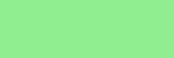

In [53]:
let
    time_index_to_view = 687; # this is the view range index, i.e., it starts with start_index. So i = 1 => start_index in raw time
    t = view_range[time_index_to_view]; # set 
    
    next_state_array = edge_cell_next_state_dictionary[t]
    new_display_frame = Array{RGB,2}(undef, 1, number_of_edge_cells);
    for j ∈ 1:number_of_edge_cells
        new_display_frame[1,j] = next_state_array[j] |> s -> my_color_dictionary[s];
    end
    display(new_display_frame) 
end

### TODO: Run the simulation with updating edge agents
Finally, let's simulate the evolution of the expert technical agents and the agents who follow our custom rule described in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance [using the `solve(...)` method exported by the `VLQuantitativeFinancePackage.jl` package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}).
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) takes three arguments: the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance, the `initialstate::Array{Int64,2}` of the population of agents, and the number of turns to simulate in the `steps::Int64` argument. Unlike the example, we take `1-step` forward each turn, and then the boundary agents get updated using the `mtp decision rule` from above to set their state. We then set the updated frame as the initial condition for the next step.
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) returns the `frames::Dict{Int64, Array{Int64,2}}` dictionary which holds the state of the system, encoded as a `number_of_rows` $\times$ `number_of_cols` array holding the agent state $s_{ij}$ values, for each turn, starting at `0` up to `1.` We copy the frame at the end of the single step, this becomes the initial state for the next step, after we update the state of the edge cells.

In [55]:
simulation_dictionary = Dict{Int64,Array{Int64,2}}();
previous_state_array = copy(initialstate);
for i ∈ eachindex(view_range)
    t = view_range[i];

    # update edge cells in the previous state -
    edge_cell_state_array = edge_cell_next_state_dictionary[t];
    for j ∈ 1:number_of_edge_cells
        coordinate = edge_coordinate_dictionary[j];
        previous_state_array[coordinate[1],coordinate[2]] = edge_cell_state_array[j];
    end

    # run the simulated 1-turn
    frames = solve(policy_model, previous_state_array, steps = 1);
    
    # get the frame -
    previous_state_array = copy(frames[1]);
    simulation_dictionary[t] = frames[1];
end

#### TODO: Visualize the network of agents
Let's visualize the data in the `simulation_dictionary::Dict{Int64,Array{Int64,2}}` variable [using the `display(...)` method exported by the Images.jl package](https://github.com/JuliaImages/Images.jl). 

`Unhide` and `uncomment` the code block below to play a movie of the data generated by the simulation loop above. This code iterates over the `view_range::Array{Int64,1}` array, which holds the indexes of the turns in the simulation. For each turn, we access the data frame from the `simulation_dictionary::Dict{Int64, Array{Int64,2}}` dictionary, recolor this data frame using the `my_color_dictionary::Dict{Int64, RGB}` dictionary, and display the recolored frame using [the `display(...)` method exported by the Images.jl package](https://github.com/JuliaImages/Images.jl). 
* Initially, all agents are in the hold state (white). However, the edge cells, using the `mtp-decision-rule` specified above, eventually initiate a transition in the population that propagates through the network of agents, assuming policy `(022110002)₃`, or `rule-index = 6158`, until there is an autonomous random pattern of hold, buy and sell activity.
* Another interesting rule is `(222110002)₃` or `rule_index = 19280`, which has similar dynamics to `(022110002)₃` in many ways. However, temporary bursts of sell-state activity occur throughout the grid world. These bursts persist over a few turns and then disappear. 

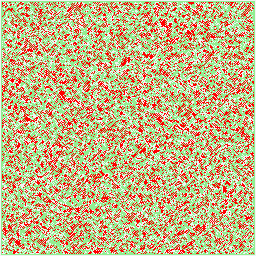

t = 1560 min


In [58]:
for i ∈ eachindex(view_range)
    t = view_range[i];
    myframe = simulation_dictionary[t];
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = myframe[j,k] |> s -> my_color_dictionary[s];
        end
    end
    display(new_display_frame)
    println("t = $(t) min")
    IJulia.clear_output(true)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.